In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt



def safe_fit_ellipse(cnt):
    if len(cnt) < 5:
        return None
    try:
        ellipse = cv2.fitEllipse(cnt)
        (cx, cy), (ax1, ax2), angle = ellipse
        if (
            np.isnan(cx) or np.isnan(cy) or
            np.isnan(ax1) or np.isnan(ax2) or
            np.isnan(angle)
        ):
            return None
        return ellipse
    except cv2.error:
        return None


def ellipse_area_score(cnt, ellipse):
    (cx, cy), (ax1, ax2), angle = ellipse
    ellipse_area = np.pi * (ax1 / 2.0) * (ax2 / 2.0)
    contour_area = cv2.contourArea(cnt)

    if contour_area <= 0 or ellipse_area <= 0:
        return 0.0
    
    if ax2 < 20:
        return 0.0  # the major axis should not be that small

    return min(contour_area, ellipse_area) / max(contour_area, ellipse_area)


def ellipse_geometric_score(cnt, ellipse):
    # Lower is better; convert to similarity score later
    (cx, cy), (ax1, ax2), angle = ellipse
    angle_rad = np.deg2rad(angle)

    R = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])

    errors = []
    for p in cnt.reshape(-1, 2):
        v = p - np.array([cx, cy])
        v_rot = R.T @ v
        x, y = v_rot
        value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2
        errors.append(abs(value - 1))

    avg_err = np.mean(errors)
    return 1.0 / (1.0 + avg_err)  # convert to similarity: high = good


def detect_best_ellipse(binary_img, write_image=None, confidence_threshold=0.8):
    '''outputs resulting_image, best_ellipse, best_score'''
    if write_image is None:
        write_image = binary_img
    
    # Normalize input
    if binary_img.dtype != np.uint8:
        img = (binary_img > 0).astype(np.uint8) * 255
    else:
        img = binary_img.copy()

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_score = -1
    best_ellipse = None

    for cnt in contours:
        ellipse = safe_fit_ellipse(cnt)
        if ellipse is None:
            continue

        area_score = ellipse_area_score(cnt, ellipse)      # [0, 1]
        geom_score = ellipse_geometric_score(cnt, ellipse) # ~[0, 1]

        final_score = 0.5 * area_score + 0.5 * geom_score

        if final_score > best_score:
            best_score = final_score
            best_ellipse = ellipse

    # Draw result
    result = write_image

    if best_ellipse is not None:
        cv2.ellipse(result, best_ellipse, (0, 255, 0), 2)
        
    if best_score < confidence_threshold:
        cv2.ellipse(result, best_ellipse, (0, 0, 255), 2)


    return result, best_ellipse, best_score


In [3]:
def write_data(image, detection, score):
    if not detection is None:
        cv2.putText(image, f"Score: {score :.2f} Height: {detection[1][0] :.2f}, Width: {detection[1][1] :.2f}", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
    else:
        cv2.putText(image, "No Detection", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
    return image

In [4]:
import cv2
import numpy as np

cap = cv2.VideoCapture('./downstairs2_cross_court.mp4')
ret, current_frame = cap.read()
if not ret:
    raise RuntimeError("Could not read video")

previous_frame = current_frame.copy()

h, w = current_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("diff_video.mp4", fourcc, 10, (w, h))

i = 0
heights = []
scores = []
while True:
    ret, current_frame = cap.read()
    i += 1
    print("processing frame", i, end="\r")
    if i < 300:
        continue
    if not ret or i >= 1000:
        break


    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    prev_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    
    current_lab = cv2.cvtColor(current_frame, cv2.COLOR_BGR2Lab)
    current_lab[:, :, 0] = 0.5
    prev_lab = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2Lab)
    prev_lab[:, :, 0] = 0.5

    frame_diff = cv2.absdiff(current_lab, prev_lab)
    frame_diff[:, :, 0] = 0
    # diff_rgb = np.stack([frame_diff]*3, axis=-1)
    
    distances = frame_diff[:, :, 0] ** 2 + frame_diff[:, :, 1] ** 2
    pixels = np.where(distances > 10)
    threshold_arr = np.zeros((frame_diff.shape[0], frame_diff.shape[1]), dtype=np.uint8)
    threshold_arr[pixels] = distances[pixels[0], pixels[1]]
    # threshold_arr = cv2.GaussianBlur(threshold_arr, (9, 9), 2)
    
    circled_frame, detection, score = detect_best_ellipse(threshold_arr, write_image=current_frame.copy())
    if not detection is None and score > 0.8:
        heights.append(detection[1][0])
        scores.append(score)
    # else:
    #     heights.append(0)
    #     scores.append(0)
    # circled_frame = np.stack((circled_frame, circled_frame, circled_frame), axis=-1)
    
    circled_frame = write_data(circled_frame, detection, score)
    # video.write(circled_frame)
    video.write(circled_frame)

    previous_frame = current_frame.copy()

video.release()
cap.release()


/tmp/ipykernel_70646/321015835.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2
/tmp/ipykernel_70646/321015835.py:53: RuntimeWarning: invalid value encountered in scalar divide
  value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2


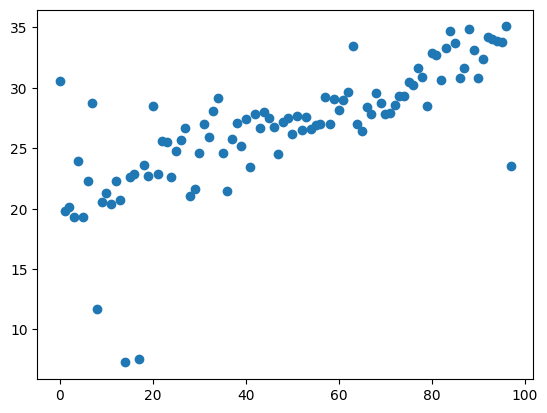

In [5]:
fig, axes = plt.subplots(1, 1)
axes.scatter(list(range(len(heights))), heights)
# axes[1].plot(list(range(len(scores))), scores)

In [ ]:
def simple_moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    sma = np.convolve(data, weights, mode='valid')
    return sma

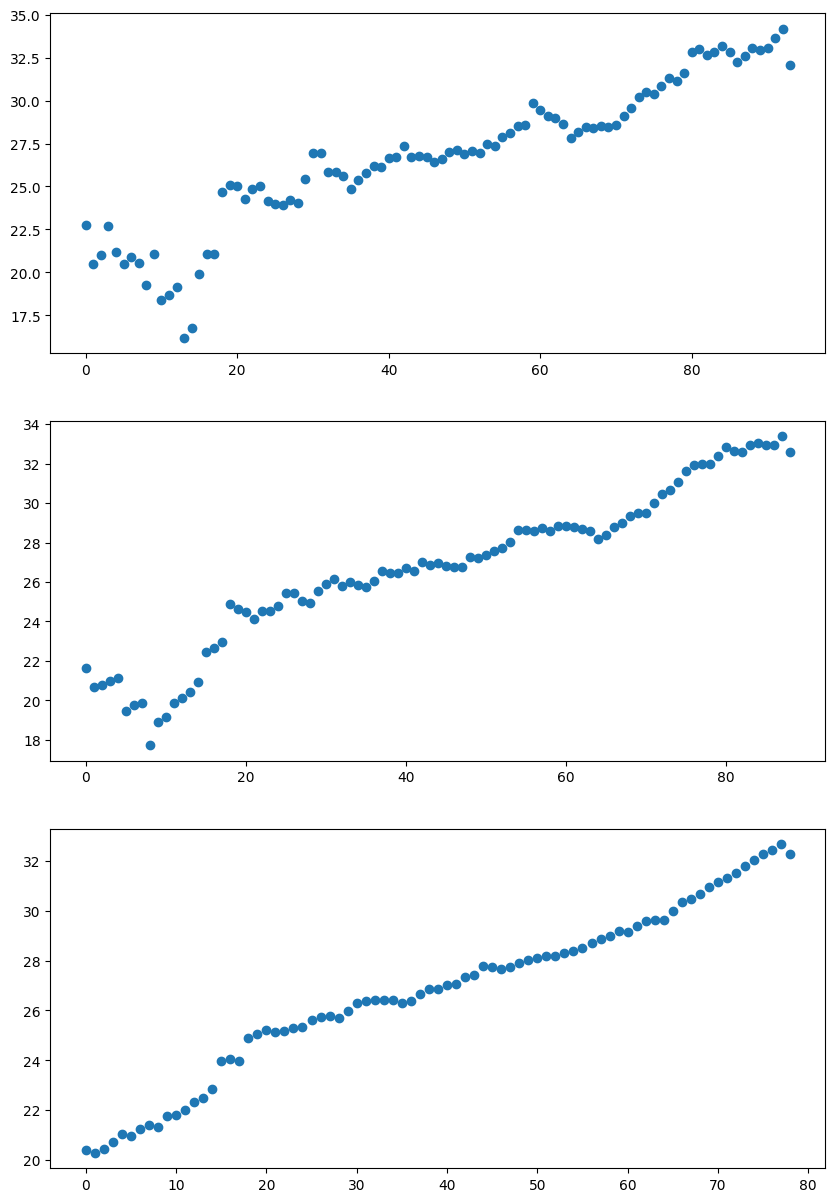

In [12]:
fig, axes = plt.subplots(3, 1)
fig.set_figheight(15)
fig.set_figwidth(10)
smooth_heights5 = simple_moving_average(heights, 5)
smooth_heights10 = simple_moving_average(heights, 10)
smooth_heights20 = simple_moving_average(heights, 20)

axes[0].scatter(list(range(len(smooth_heights5))), smooth_heights5)
axes[1].scatter(list(range(len(smooth_heights10))), smooth_heights10)
axes[2].scatter(list(range(len(smooth_heights20))), smooth_heights20)


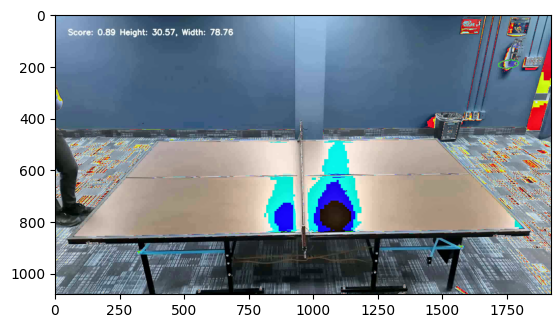

In [ ]:
cap = cv2.VideoCapture("./diff_video.mp4")
ret, frame = cap.read()
plt.imshow(frame * 2)